In [1]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
import os
os.chdir("/content/drive/MyDrive/Diplomatic2/Implementation")
!ls

 AGNN_1			    elliptic_txs_edgelist.csv   GRL_2.ipynb
 AGNN_2			    elliptic_txs_features.csv  'GRL_FINAL (4).ipynb'
 AGNN_3			    GAT_1		        GRL.ipynb
 data_balanced_1000.obj     GAT_2		        Node2Vec
 data_balanced_500.obj	    GAT_2_1		        NoteBooks
 data.obj		    GAT_3		        SAGE_1
 DGI			    GAT_FL_1		        SAGE_2
 elliptic_txs_classes.csv   GAT_TEST		        SAGE_3


In [ ]:
#PYTORCH INSTALL
# Add this in a Google Colab cell to install the correct version of Pytorch Geometric.
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

In [ ]:
import pickle   
import torch
from torch_geometric.data import Data

fileObj = open('data.obj', 'rb')
data3 = pickle.load(fileObj)
fileObj.close()
print(data3)

Data(x=[203769, 165], edge_index=[2, 234355], y=[203769], n_id=[203769], train_mask=[203769], val_mask=[203769], test_mask=[203769])


In [ ]:
#SCRIPT TO SAVE FEATURES FROM DATA OBJECT

os.chdir("/content/drive/MyDrive/Diplomatic2/Implementation/Node2Vec")

features_n2v = data3.x.tolist()
features_n2v_file = 'features_n2v'
file2save_everything = open(features_n2v_file,'wb')
pickle.dump(features_n2v, file2save_everything)
file2save_everything.close()

In [ ]:
#DEBUGGING CODE
a = data3.edge_index.tolist()
source = a[0]
target = a[1]
total = source + target

In [ ]:
#DEBUGGING CODE

num = len(set(total))
print(num)

203769


In [ ]:
#DEBUGGING CODE

tar = data3.y.tolist()
ones = tar.count(1)
zero = tar.count(0)
print(ones,zero)

42019 4545


In [ ]:
#USE GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
data3 = data3.to(device)


In [ ]:
#SCRIPT 30
#TRAIN EMBENDINGS
import os.path as osp
import sys

import matplotlib.pyplot as plt
import torch
from sklearn.manifold import TSNE

from torch_geometric.datasets import Planetoid
from torch_geometric.nn import Node2Vec

model = Node2Vec(data3.edge_index, embedding_dim=64, walk_length=20,
                     context_size=10, walks_per_node=10,
                     num_negative_samples=1, p=1, q=1, sparse=True).to(device)


num_workers = 0 if sys.platform.startswith('win') else 2
print(num_workers)

loader = model.loader(batch_size=128, shuffle=True,
                          num_workers=num_workers)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)                     

def train():
        model.train()
        total_loss = 0
        for pos_rw, neg_rw in loader:
            optimizer.zero_grad()
            loss = model.loss(pos_rw.to(device), neg_rw.to(device))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        return total_loss / len(loader)

2


In [ ]:
#script31
#TRAINNING
for epoch in range(1, 101):
        loss = train()
        print(loss)

In [ ]:
#SEE RESULTS
with torch.no_grad():
  model.eval()
  z = model()
print(z.shape)

torch.Size([203769, 64])


In [ ]:
#SCRIPT 30
#MAKE A COPY TO SAVE 
embendings = z.numpy(force = True)
print(type(embendings))

<class 'numpy.ndarray'>


In [ ]:
#SCRIPT 30
#SAVE EMBENDINGS
os.chdir("/content/drive/MyDrive/Diplomatic2/Implementation")

a = os.path.isdir('Node2Vec')
if a == False:
  os.mkdir("Node2Vec")

os.chdir("/content/drive/MyDrive/Diplomatic2/Implementation/Node2Vec")

emb_n2v = 'embendings_file'
file2save_everything = open(emb_n2v,'wb')
pickle.dump(embendings, file2save_everything)
file2save_everything.close()


In [ ]:
# GIVE NAMES TO COLUMNS SO JOIN WORKS
columns_ftrs = [str(i) for i in range(0,165)]
print(len(columns_ftrs))

columns_emb = [str(i) for i in range(165,165+64)]
print(len(columns_emb))

print(columns_ftrs[164])

165
64
164


In [ ]:
#SCRIPT 31
#CREATE DATAFRAME
import numpy as np
import pandas as pd


os.chdir("/content/drive/MyDrive/Diplomatic2/Implementation/Node2Vec")

emb_n2v = 'embendings_file'
features_n2v = 'features_n2v'
file2save_everything = open(emb_n2v,'rb')
emb = pickle.load(file2save_everything)
file2save_everything.close()
print(emb.shape)

file2save_everything = open(features_n2v,'rb')
ftrs = pickle.load(file2save_everything)
file2save_everything.close()
ftrs = np.array(ftrs)
print(ftrs.shape)

emb = pd.DataFrame(emb,columns=columns_emb)
ftrs = pd.DataFrame(ftrs,columns=columns_ftrs)

print(emb.shape, ftrs.shape)
#final_features = pd.concat([emb,ftrs],axis = 1)
final_set = ftrs.join(emb)
print(final_set.shape)

(203769, 64)
(203769, 165)
(203769, 64) (203769, 165)
(203769, 229)


In [ ]:
#SCRIPT 31 NO EMBENDINGS
#CREATE DATAFRAME
import numpy as np
import pandas as pd


os.chdir("/content/drive/MyDrive/Diplomatic2/Implementation/Node2Vec")

emb_n2v = 'embendings_file'
features_n2v = 'features_n2v'
file2save_everything = open(emb_n2v,'rb')
emb = pickle.load(file2save_everything)
file2save_everything.close()
print(emb.shape)

file2save_everything = open(features_n2v,'rb')
ftrs = pickle.load(file2save_everything)
file2save_everything.close()
ftrs = np.array(ftrs)
print(ftrs.shape)

emb = pd.DataFrame(emb,columns=columns_emb)
ftrs = pd.DataFrame(ftrs,columns=columns_ftrs)

print(emb.shape, ftrs.shape)
#final_features = pd.concat([emb,ftrs],axis = 1)
final_set = emb
print(final_set.shape)

(203769, 64)
(203769, 165)
(203769, 64) (203769, 165)
(203769, 64)


In [ ]:
#DEBUGGING
#print(final_set.iloc[[1]])
final_set.to_csv('dataframe.csv', index=False)


In [ ]:
#SCRIPT 32
train_msk = data3.train_mask.tolist()
print(type(train_msk))

val_msk = data3.val_mask.tolist()
print(type(train_msk))

test_msk = data3.test_mask.tolist()
print(type(train_msk))

X_train = final_set[train_msk]
print(X_train.shape)
print(type(X_train))

X_val = final_set[val_msk]
print(X_val.shape)
print(type(X_val))

X_test = final_set[test_msk]
print(X_test.shape)
print(type(X_test))

<class 'list'>
<class 'list'>
<class 'list'>
(2500, 229)
<class 'pandas.core.frame.DataFrame'>
(15000, 229)
<class 'pandas.core.frame.DataFrame'>
(29064, 229)
<class 'pandas.core.frame.DataFrame'>


In [ ]:
#SCRIPT32
targets = data3.y.tolist()
print(len(targets))
targets = pd.DataFrame(targets)
print(targets.shape)

Y_train = targets[train_msk]
print(len(Y_train))
print(type(Y_train))

Y_val = targets[val_msk]
print(len(Y_val))
print(type(Y_val))

Y_test = targets[test_msk]
print(len(Y_test))
print(type(Y_test))

203769
(203769, 1)
2500
<class 'pandas.core.frame.DataFrame'>
15000
<class 'pandas.core.frame.DataFrame'>
29064
<class 'pandas.core.frame.DataFrame'>


In [ ]:
#SCRIPT 33
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,Y_train)

y_pred=clf.predict(X_test)

<ipython-input-9-4454344ee325>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train,Y_train)


In [ ]:
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(Y_test, y_pred))

Accuracy: 0.9130195430773466


In [ ]:
from sklearn.metrics import confusion_matrix
print('Confussion Matrix',confusion_matrix(Y_test, y_pred))

Confussion Matrix [[  123  2422]
 [  106 26413]]


In [ ]:
from sklearn.metrics import recall_score
print('RECALL',recall_score(Y_test, y_pred,average=None))

RECALL [0.04833006 0.99600287]


In [ ]:
from sklearn.metrics import precision_score
print('PRECISION',precision_score(Y_test, y_pred,average=None))

PRECISION [0.5371179  0.91600486]


In [ ]:
from sklearn.metrics import f1_score
print('F1 SCORE',f1_score(Y_test, y_pred,average=None))

F1 SCORE [0.08868061 0.95433031]


In [ ]:
#GET SCORE FOR EACH FEATURE
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier

clf_dt = DecisionTreeClassifier()
clf_dt.fit(X_train,Y_train)
y_pred=clf_dt.predict(X_test)

In [ ]:
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(Y_test, y_pred))

from sklearn.metrics import confusion_matrix
print('Confussion Matrix',confusion_matrix(Y_test, y_pred))

from sklearn.metrics import recall_score
print('RECALL',recall_score(Y_test, y_pred,average=None))

from sklearn.metrics import precision_score
print('PRECISION',precision_score(Y_test, y_pred,average=None))

from sklearn.metrics import f1_score
print('F1 SCORE',f1_score(Y_test, y_pred,average=None))

Accuracy: 0.9347302504816956
Confussion Matrix [[ 2217   328]
 [ 1569 24950]]
RECALL [0.87111984 0.94083487]
PRECISION [0.58557845 0.98702429]
F1 SCORE [0.70036329 0.96337626]


Index(['125', '127', '128', '129', '130', '131', '132', '133', '134', '124',
       ...
       '191', '172', '171', '175', '15', '162', '17', '58', '52', '89'],
      dtype='object', length=228)


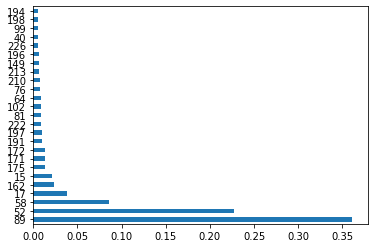

In [ ]:
import matplotlib.pyplot as plt

importance = clf_dt.feature_importances_
index = np.argsort(importance)[-228:]
#print(np.sum(importance[index]))
colname = final_set.columns[index]
print(colname)
feat_importances = pd.Series(clf_dt.feature_importances_, index=X_train.columns)
feat_importances.nlargest(25).plot(kind='barh')
plt.show()

In [ ]:
import numpy
#print(colname[-100:])
colname2 = [int(i) for i in colname]
print(colname2[-100:])
indexes = [index for index,value in enumerate(colname2) if value > 164]


[33, 14, 34, 35, 36, 37, 39, 9, 21, 78, 86, 85, 84, 83, 3, 80, 79, 77, 6, 75, 74, 87, 90, 72, 2, 4, 69, 59, 60, 61, 62, 70, 8, 63, 7, 66, 67, 91, 68, 92, 5, 16, 156, 18, 135, 204, 113, 82, 199, 192, 142, 73, 184, 216, 71, 126, 209, 221, 137, 138, 93, 155, 207, 180, 169, 47, 106, 26, 225, 219, 1, 88, 43, 65, 183, 194, 198, 99, 40, 226, 196, 149, 213, 210, 76, 64, 102, 81, 222, 197, 191, 172, 171, 175, 15, 162, 17, 58, 52, 89]


In [ ]:
print(colname2[227])
#print(indexes)

89


In [ ]:
results = [i for i in indexes if i>227-50]

In [ ]:
print(len(results))

22
